In [412]:
import numpy as np
import fenics as fen
import scipy.sparse

class MaxwellProblem(object):
    """
    Finite element solver for problems of the type
    
        \/ x ((1 / mu) \/ x A) - eps * omega^2 * A = j

    with boundary conditions

        A = A_0                     (Dirichlet boundaries, B_D)
        ((1 / mu) \/ x A) x n = g   (Neumann boundaries, B_N)
 
    Members
    -------
    V : dolfin.functions.functionspace.FunctionSpace
        Real FE space.
    A : dolfin.functions.function.TrialFunction
        Trial function.
    v : dolfin.functions.function.TestFunction
        Test function.
    K : dolfin.cpp.la.Matrix
        Stiffness matrix.  
    M : dolfin.cpp.la.Matrix
        Mass matrix.
    L : dolfin.cpp.la.Vector
        Source term vector.
    mu : dolfin.functions.expression.Expression
        Permeability.
    eps : dolfin.functions.expression.Expression
        Permittivity.
    j : dolfin.functions.expression.Expression
        Current density
    B_D : dolfin.cpp.mesh.SubDomain
        SubDomain object locating the Dirichlet boundary.
    B_N : dolfin.cpp.mesh.SubDomain
        SubDomain object locating the Neumann boundary.
    A_0 : dolfin.functions.expression.Expression
        Dirichlet boundary condition.
    g : dolfin.functions.expression.Expression
        Neumann boundary condition.
    A_sol : dolfin.functions.function.Function
        Solution to the variational problem.
    F_norm : dolfin.cpp.la.Matrix
        Matrix used to compute L2-norm of A_sol.
    bc : dolfin.fem.bcs.DirichletBC
        Dirichlet boundary condition object.
    omega : float
        Frequency for which the variational problem is solved.

    Methods
    -------
    tosparse(A) : dolfin.cpp.la.Matrix -> scipy.sparse.csr_matrix
        Convert dolfin matrix to scipy sparse matrix in the CSR format.
    setup() : None -> None
        Assemble the stiffness, mass, and source terms.
    solve(omega) : float -> None
        Computes the solution to the weak variational problem at omega.

    References
    ----------
    [1] TODO
    
    Usage
    -----
    [TODO: Minimal usage example]
    """

    def __init__(self, V, mu, eps, j, B_D, B_N, A_0, g):
        self.V = V
        self.A = fen.TrialFunction(self.V)
        self.v = fen.TestFunction(self.V)
        self.K = None
        self.M = None
        self.L = None
        self.N = None
        self.mu = mu
        self.eps = eps
        self.j = j
        self.B_D = B_D
        self.B_N = B_N
        self.A_0 = A_0
        self.g = g
        self.A_sol = None
        self.F_norm = None
        self.bc = None
        self.omega = None

    def setup(self):
        # Boundary function to indicated Dirichlet and Neumann boundaries
        what_boundary = fen.MeshFunction('size_t', mesh, mesh.topology().dim() - 1)
        self.B_N.mark(what_boundary, 1)
        self.B_D.mark(what_boundary, 2)

        # Neumann boundary conditions
        #ds = fen.Measure('ds', subdomain_data=what_boundary)
        self.N = fen.assemble(fen.dot(self.g, self.v) * fen.ds) #(2))

        # Dirichlet boundary conditions
        self.bc = fen.DirichletBC(self.V, self.A_0, what_boundary, 2)

        # Assembly of stiffness, mass, and forcing term
        self.K = fen.assemble(1/self.mu * fen.dot(fen.curl(self.A), fen.curl(self.v)) * fen.dx)
        self.bc.apply(self.K)

        self.M = fen.assemble(self.eps * fen.dot(self.A, self.v) * fen.dx)
        self.bc.zero(self.M)

        self.L = fen.assemble(fen.dot(self.j, self.v) * fen.dx)
        self.bc.apply(self.L)

    def solve(self, omega):
        self.omega = omega
        LHS = self.K - omega**2 * self.M
        RHS = self.L + self.N
        self.A_sol = fen.Function(self.V)
        fen.solve(LHS, self.A_sol.vector(), RHS)

    @staticmethod
    def tosparse(A):
        A_mat = fen.as_backend_type(A).mat()
        A_sparse = scipy.sparse.csr_matrix(A_mat.getValuesCSR()[::-1])
        return A_sparse

    def get_K(self): 
        return self.tosparse(self.K)
    
    def get_M(self): 
        return self.tosparse(self.M)
    
    def get_L(self): 
        return self.L.get_local()
    
    def get_solution(self):
        return self.A_sol

    def compute_solution_norm(self):
        if self.F_norm is None:
            self.F_norm = fen.assemble(fen.dot(fen.TrialFunction(V), fen.TestFunction(V)) * fen.dx)
        return pow((self.A_sol.vector()*(self.F_norm*self.A_sol.vector())).sum(), 0.5)
    
    def get_boundary_indices_and_values(self):
        boundary_dict = self.bc.get_boundary_values()
        boundary_indices = list(boundary_dict.keys())
        boundary_values = list(boundary_dict.values())
        return boundary_indices, boundary_values

    def get_valid_indices(self):
        boundary_indices, _ = self.get_boundary_indices_and_values()
        all_indices = V.dofmap().dofs()
        valid_indices = np.delete(all_indices, boundary_indices)
        return valid_indices
    
    def insert_boundary_values(self, A_vec):
        boundary_indices, boundary_values = self.get_boundary_indices_and_values()
        valid_indices = self.get_valid_indices()
        A_vec_inserted = np.empty(len(boundary_indices) + len(valid_indices))
        A_vec_inserted[valid_indices] = A_vec
        A_vec_inserted[boundary_indices] = boundary_values
        return A_vec_inserted

In [413]:
class RectangularWaveguide(MaxwellProblem):
    def __init__(self, Lx, Ly, res, g):
        domain = mshr.Rectangle(fen.Point(0.0, 0.0), fen.Point(Lx, Ly))
        mesh = mshr.generate_mesh(domain, n)
        self.V = fen.FunctionSpace(mesh, 'P', 1)

        mu = fen.Expression('1.0', degree=2)
        eps = fen.Expression('1.0', degree=2)
        j = fen.Expression('0.0', degree=2)

        class B_N(fen.SubDomain):
            def inside(self, x, on_boundary):
                return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<Ly

        class B_D(fen.SubDomain):
            def inside(self, x, on_boundary):
                return on_boundary and not B_N().inside(x, 'on_boundary')

        A_0 = fen.Expression('0.0', degree=2)

        MaxwellProblem.__init__(self, V, mu, eps, j, B_D(), B_N(), A_0, g)

    def plot_solution(self):
        plt.title(f'Solution to system at frequency \u03A9 = {self.omega} rad/s')
        fig = fen.plot(self.A_sol)
        plt.colorbar(fig, orientation='horizontal')

    def plot_external_solution(self, A_vec, omega=None):
        plt.figure()
        if omega is not None:
            plt.title(f'Solution to system at frequency \u03A9 = {omega} rad/s')
        A_func = fen.Function(self.V)
        A_func.vector()[:] = self.insert_boundary_values(A_vec)
        fen.plot(A_func)
        fig = fen.plot(self.A_sol)
        plt.colorbar(fig, orientation='horizontal')
        plt.show()

    def get_analytical_eigenfrequencies(self, a, b):
        freqs = lambda n, m: np.pi*pow(n**2/(Ly)**2 + (m+0.5)**2/(Lx)**2 , 0.5)
        n_max = np.ceil(b * Ly / np.pi).astype('int')
        m_max = np.ceil(b * Lx / np.pi - 0.5).astype('int')
        eigs = np.unique(np.frompyfunc(freqs, 2, 1).outer(range(1, n_max+1), range(m_max+1)))
        return [e for e in eigs if a <= e and e <= b]

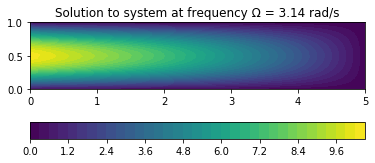

In [414]:
WG = RectangularWaveguide(Lx=1., Ly=5., res=64, g=fen.Expression('1.', degree=2))
WG.setup()
WG.solve(3.14)
WG.plot_solution()

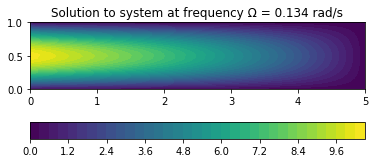

In [417]:
WG.plot_external_solution(ev[3], 0.134)

In [415]:
import scipy.sparse.linalg

def solve_eigenproblem(K, M, a=-np.inf, b=np.inf, k=10, valid_indices=None, v0=None):

    if valid_indices is not None:
        K = K[valid_indices, :][:, valid_indices]
        M = M[valid_indices, :][:, valid_indices]
        if v0 is not None:
            v0 = v0[valid_indices]
    
    if a == -np.inf or b == np.inf:
        sigma = 0.0
    else:
        sigma = (a + b) / 2.0
    eigvals, eigvecs = scipy.sparse.linalg.eigsh(K, k=k, M=M, sigma=sigma, v0=v0)

    eigvals_in_ab = [e1 for e1 in eigvals if a <= e1 and e1 <= b]
    eigvecs_in_ab = [e2 for e1, e2 in zip(eigvals, eigvecs.T) if a <= e1 and e1 <= b]

    if len(eigvals_in_ab) == k:
        print(f'WARNING: Found exactly {k} eigenvalues within [{a}, {b}].')
        print('Increase parameter "k" to make sure all eigenvalues are found.')
    
    return eigvals_in_ab, eigvecs_in_ab

In [419]:
def plot_L2_norms(ax, WG, omegas):
    L2_norms = np.empty(len(omegas))
    for i, omega in enumerate(omegas):
        WG.solve(omega)
        L2_norms[i] = WG.compute_solution_norm()
    ax.plot(omegas, L2_norms)
    ax.set_yscale('log')

In [420]:
def plot_analytical_eigenfrequencies(ax, WG, a, b, **kwargs):
    eigenfrequencies = WG.get_analytical_eigenfrequencies(a, b)
    ax.vlines(eigenfrequencies, ymin=0, ymax=1, **kwargs)

In [421]:
def plot_numerical_eigenfrequencies(ax, WG, a, b, **kwargs):
    K = WG.get_K()
    M = WG.get_M()
    valid_indices = WG.get_valid_indices()
    eigenfrequencies, _ = solve_eigenproblem(K, M, a=a, b=b, k=10, valid_indices=None, v0=None)
    ax.vlines(np.sqrt(eigenfrequencies), ymin=1, ymax=2, **kwargs)

In [422]:
def eigvec_dot_N(eigvec, V, bc, L):
    full_eigvec = insert_boundary_values(eigvec, V, bc)
    return np.inner(full_eigvec, L.get_local())
# TODO: def plot_eigvec_dot_N(ax, ...)

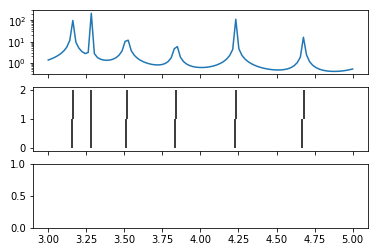

In [423]:
fig, ax = plt.subplots(3, 1, sharex=True)
omegas = np.linspace(3, 5, 100)
plot_L2_norms(ax[0], WG, omegas)
plot_numerical_eigenfrequencies(ax[1], WG, omegas[0]**2, omegas[-1]**2)
plot_analytical_eigenfrequencies(ax[1], WG, omegas[0], omegas[-1])